In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm

from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

In [2]:
# X, y = make_classification(n_samples=1_000_000, n_informative=6, n_classes=3, weights=(0.5, 0.4, 0.1), random_state=42)

from sklearn.datasets import fetch_openml

def make_n_classes(n, y):
    dic = dict(zip(y.value_counts().head(n - 1).index, range(n - 1)))
    return np.array(list(map(lambda x: dic.get(x, n - 1), y)))

def read_dataset():
    X, y_original = fetch_openml(
        data_id=4541, parser='auto', return_X_y=True, as_frame=True
    )
    y = make_n_classes(3, y_original)
    X = X.drop(columns=['encounter_id', 'patient_nbr'])
    return X, y

___

Para ilustrar a discussão de otimização de threshold no caso multiclasse usaremos o [`sklearn.datasets.fetch_openml`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html) com `data_id=4541` e o tornaremos um dataset com três classes, mas, como veremos adiante, a estratégia é genérica para qualquer número de classes. A escolha de 3 foi apenas para uma melhor visualização.

In [3]:
X, y = read_dataset()

X_train_model, X_test, y_train_model, y_test = train_test_split(X, y, random_state=0, stratify=y)
X_train_model, X_train_threshold, y_train_model, y_train_threshold = \
train_test_split(X_train_model, y_train_model, test_size=0.2, random_state=0, stratify=y_train_model)

Em um problema de classificação multiclasse (com `n` classes), o output "probabilístico" de um típico classificador do scikit-learn será um vetor com `.shape` de `(n_samples, n)`. Para cada exemplo esse vetor de `n` componentes nos dá a "probabilidade" de cada exemplo pertencer a classe associada àquele índice. Ou seja, a primeira componente é a probabilidade dos exemplos pertencerem à primeira classe, a segunda componente as probabilidades da segunda classe e assim por diante.

In [4]:
model = LGBMClassifier(random_state=42).fit(X_train_model, y_train_model)

probs = model.predict_proba(X_train_threshold)
preds = model.predict(X_train_threshold)

print(f"Number of samples in X_train_threshold: {X_train_threshold.shape[0]}.",
      f"Number of classes: {len(np.unique(y))}.",
      f"\nprobs.shape: {probs.shape}.")

Number of samples in X_train_threshold: 15265. Number of classes: 3. 
probs.shape: (15265, 3).


Por representar uma probabilidade, esse vetor é tal que suas linhas sempre somam 1, ou seja, a probabilidade de uma amostrar estar em uma das classes é 1.

In [5]:
(np.isclose(probs.sum(axis=1), 1)).all()

True

O espaço de vetores de `n` dimensões tal que suas componentes somam 1 é chamado de simplex do $\mathbb{R}^n$, ou apenas n-simplex. No caso em que o número de classes é 2, então o simplex se torna simplesmente uma linha que vai do ponto $(1, 0)$ ao ponto $(0, 1)$ e pode ser parametrizado diretamente pela probabilidade de uma das classes, por exemplo como $\left\{ (1-p, p) : p \in [0, 1] \right\}$. Essa simplificação é o motivo para as métricas de classificação binária de bibliotecas famosas de aprendizado de máquina como o scikit-learn pedirem para você passar apenas a probabilidade da segunda classe para suas funções que calculam essas métricas fazendo algo como `roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])`.


Essa simplificação do simplex de dimensão 2 para uma linha permite que você escolha thresholds de maneira razoavelmente simples para transformar o output probabilístico do modelo em previsões duras (ou seja, escolhendo apenas uma das classes).

Já discutimos, em um [post anterior sobre otimização de hiperparâmetros para métricas dependentes de threshold](https://vitaliset.github.io/threshold-dependent-opt/) um pouco sobre uma estratégia possível para executar essa transformação. Em pseudo-code:

```plaintext
1. Define a metric of interest that you want to optimize with the
threshold-setting process.
2. Select several different threshold values t in (0, 1) interval such that
your new .predict will be of the form "if .predict_proba > t, then predict 1;
otherwise, predict 0. In general, you can create a simple grid using
np.linspace.
3. Calculate your metric with each possible value of t from your grid of values
and choose the best threshold value (according to some criterion - for example,
the threshold that explicitly provided the best value for your metric of
interest).
```

Isso funciona bem para o caso binário, mas não é imediato extender essa ideia para o caso de três classes e muito menos para um caso genérico em que temos `n` classes. Por exemplo, para três classes, o 3-simplex que antes era uma linha, se torna um triângulo, um objeto um pouco mais complexo de se dividir.

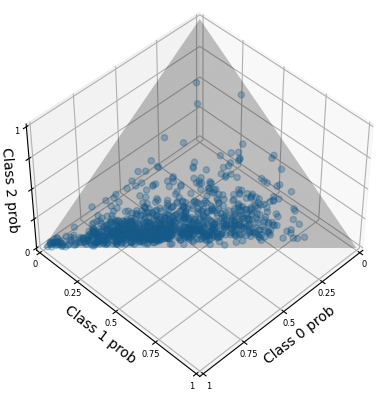

In [6]:
from utils import plot_simplex, clean_simplex_ax, plot_3d_regions_over_simplex

plot_sample = np.random.RandomState(42).choice(len(probs), 1000, replace=False)

ax = clean_simplex_ax(plot_simplex())
ax.scatter(xs=probs[plot_sample, 0], ys=probs[plot_sample, 1], zs=probs[plot_sample, 2], alpha=0.3)

plt.show()

Não é imediato pensar em como parametrizar a divisão desse objeto em três regiões, diferente da trivial divisão do simplex de dimensão dois onde definir o `t` bastava para uma região ficar sendo prevista como um valor e a outra região com outra.

A ideia desse post é tentar atacar esse problema, de uma forma genérica o suficiente para ser aplicável em problemas com um número `n` de classes qualquer.

___

## Entendendo o predict usual

In scikit-learn, the implementation of `.predict`, in general, follows the logic [implemented](https://github.com/scikit-learn/scikit-learn/blob/98cf537f5c538fdbc9d27b851cf03ce7611b8a48/sklearn/ensemble/_forest.py#L800-L837) for [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html):
```python
def predict(self, X):
    ...
    proba = self.predict_proba(X)
    ...
    return self.classes_.take(np.argmax(proba, axis=1), axis=0)
```

Isso significa que dado um vetor no simplex, o valor previsto é o da componente tal que ele é maior. Isso na verdade é equivalente a encontrar qual o vértice mais perto daquele ponto do simplex.

**Teorema**: Seja $\textbf{p} = (p_1, p_2, p_3)$, $\textbf{v}_1 = (1, 0, 0)$, $\textbf{v}_2 = (0, 1, 0)$ e $\textbf{v}_3 = (0, 0, 1)$ vetores no 3-simplex de $\mathbb{R}^3$. Então $p_i$ é o maior elemento de $\textbf{p}$ se e somente se $\textbf{p}$ está mais próximo (no sentido de distância euclidiana) do ponto $\textbf{v}_i$ do que dos pontos $\textbf{v}_j$ para $j\neq i$. 

**Demonstração**: TODO

Podemos verificar tal fato no nosso exemplo utilizando um [`sklearn.neighbors.NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) e verificando que o índice do vizinhos mais próximo de fato coincidem com o valor que o nosso `.predict` nos retornou anteriormente.

In [7]:
edges_of_simplex = np.identity(3)
edges_of_simplex

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [8]:
nn = NearestNeighbors(n_neighbors=1, p=2).fit(edges_of_simplex)
_, ind = nn.kneighbors(probs)

(ind[:, 0] == preds).all()

True

Vendo tal fato visualmente, temos que o diagrama de Voronoi das quinas quebra o simplex nas regiões definidas pelo [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html).

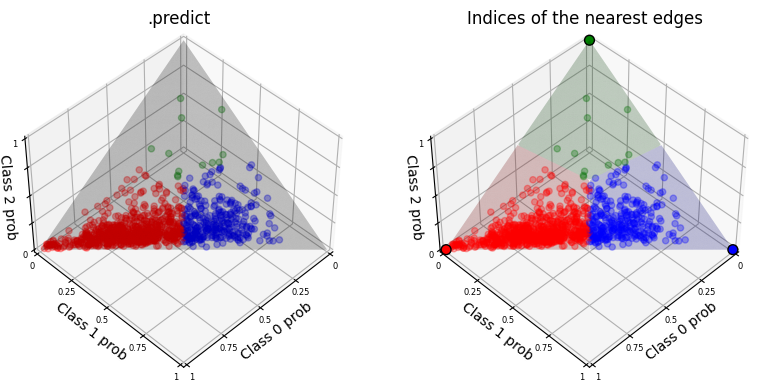

In [9]:
color_dic = dict(zip(range(3), ['r', 'b', 'g']))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = (
    fig.add_subplot(1, 2, 1, projection='3d'),
    fig.add_subplot(1, 2, 2, projection='3d')
)


color_list_preds = [color_dic[x] for x in preds[plot_sample]]
ax[0].scatter(
    probs[plot_sample, 0],
    probs[plot_sample, 1],
    zs=probs[plot_sample, 2],
    c=color_list_preds, alpha=0.3
)
ax[0].set_title(".predict")
plot_simplex(ax[0])

color_list_nn = [color_dic[x] for x in ind[plot_sample, 0]]
ax[1].scatter(
    xs=probs[plot_sample, 0],
    ys=probs[plot_sample, 1],
    zs=probs[plot_sample, 2],
    c=color_list_nn, alpha=0.3
)
ax[1].scatter(
    xs=edges_of_simplex[:, 0],
    ys=edges_of_simplex[:, 1],
    zs=edges_of_simplex[:, 2],
    c=['r', 'b', 'g'], s=50, edgecolor='k', alpha=1
)
ax[1].set_title("Indices of the nearest edges")
plot_3d_regions_over_simplex(nn, ax[1])

for axis in ax:
    clean_simplex_ax(axis)

plt.show()

Isso não acontece apenas no caso de dimensão 3 e é possível generalizar o nosso teorema para qualquer número de dimensões. Aqui, vamos ver isso acontecendo computacionamente da mesma forma que testamos no caso de três classes.

In [10]:
from sklearn.ensemble import RandomForestClassifier

for N_CLASSES in tqdm(range(2, 11)):
    X_n_classes, y_n_classes = make_classification(
        n_samples=1000, n_features=30, n_informative=22, n_classes=N_CLASSES, random_state=42
    )

    model_n_classes = RandomForestClassifier(max_depth=4, random_state=42).fit(X_n_classes, y_n_classes)

    probs_n_classes = model_n_classes.predict_proba(X_n_classes)
    preds_n_classes = model_n_classes.predict(X_n_classes)

    edges_of_simplex_n_classes = np.identity(N_CLASSES)

    nn_n_classes = NearestNeighbors(n_neighbors=1, p=2).fit(edges_of_simplex_n_classes)

    _, ind_n_classes = nn_n_classes.kneighbors(probs_n_classes)
    assert (ind_n_classes[:, 0] == preds_n_classes).all()

100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Essa percepção nos permite tentar extender essa ideia: e se movermos o que estávamos chamando de quinas para outros pontos do meu simplex e construir o diagrama de Voronoi com esses novos centroides?

___

## Definindo novos centroides do diagrama de Voronoi

Podemos sortear pontos aleatórios do nosso simplex para serem nossos novos candidatos a "quinas". Esses novos pontos definem [diagramas de influência (Voronoi)](https://en.wikipedia.org/wiki/Voronoi_diagram) diferentes dos iniciais em que os centroides eram os do tipo `centroids_candidates = np.identity(3)`.

Para sortear pontos de uma maneira uniforme no simplex, precisamos usar um pequeno truque implementado na função `sample_uniform_random_vectors_over_simplex`.

In [11]:
# https://stackoverflow.com/questions/65154622/sample-uniformly-at-random-from-a-simplex-in-python
def sample_uniform_random_vectors_over_simplex(n, d=3, random_state=None):
    """Generate uniformly random vectors over a d-simplex.

    Parameters
    ----------
    n : int
        The number of random vectors to generate.

    d : int, default=3
        The dimension of the simplex.

    random_state : int or None, default=None
        Controls the random number generator used to generate the random
        vectors. Pass an int for reproducible results across multiple function
        calls.

    Returns
    -------
    random_sample : array-like of shape (n, d)
        The n uniformly random vectors in the d-simplex.

    Notes
    -----
    This function uses an exponential distribution to generate random points
    within the simplex.

    References
    ----------
    .. [1] Onn, S., & Weissman, I. (2011). Generating uniform random vectors
    over a simplex with implications to the volume of a certain polytope and
    to multivariate extremes. Annals of Operations Research, 189(1), 331-342.

    Examples
    --------
    >>> random_vectors = uniform_random_vectors_over_simplex(5, d=3)
    """
    random_gen = np.random.RandomState(random_state)
    k = random_gen.exponential(scale=1.0, size=(d, n))
    random_sample = (k / k.sum(axis=0)).T
    return random_sample


In [12]:
centroids_candidates = sample_uniform_random_vectors_over_simplex(n=3, d=3, random_state=10)
centroids_candidates

array([[0.47939814, 0.44888388, 0.07171798],
       [0.00979707, 0.32243709, 0.66776584],
       [0.69537845, 0.17633038, 0.12829117]])

Com os novos `centroids_candidates` sorteados, podemos aplicar a ideia anterior de quebrar o simplex pelos seus diagramas de influências.

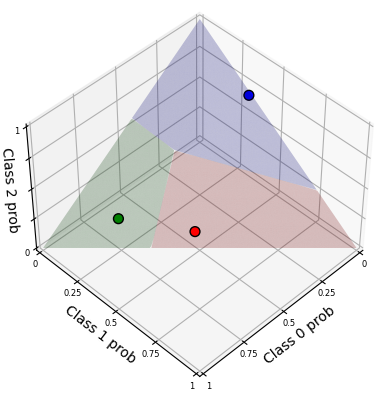

In [13]:
nn_candidates = NearestNeighbors(n_neighbors=1, p=2).fit(centroids_candidates)

ax = clean_simplex_ax(plot_3d_regions_over_simplex(nn_candidates))
ax.scatter(
    xs=centroids_candidates[:, 0],
    ys=centroids_candidates[:, 1],
    zs=centroids_candidates[:, 2],
    c=['r', 'b', 'g'], s=50, edgecolor='k', alpha=1
)
plt.show()

A estratégia que seguirá é motivada por essas novas regiões que podemos construir.

Como esses três centroides (ou de forma genérica `n` pontos) de dimensão três (ou `n`) definem como iremos quebramos o simplex em três (ou `n`) regiões diferentes, iremos fazer uma [busca aleatória](https://en.wikipedia.org/wiki/Random_search) para encontrar a posição desses centroides a fim de maximizar uma métrica de interesse. Isso é totalmente análogo à estratégia do caso binário, com a diferença que definir um grid nesse caso é muito mais difícil.

___

## Algumas restrições razoáveis no sampling de candidatos a centroides

Nem sempre o sampling aleatório irá nos retornar pontos de centroide que estou definindo como válidos. Por exemplo, o sampling anterior é tal que a quina `(1, 0, 0)` agora estaria sendo classificada como sendo da classe 2 uma vez que está na região de influencia do ponto verde.

Isso é fácil de resolver apenas fazendo uma permutação da posição dos centroides de forma que as quinas estejam sempre associadas com o centroide de indice correto, ou seja, o indice do centroide mais próximo de `(1, 0, 0)` precisa ser `0` e assim por diante.

O outro problema é um pouco mais chato. Dependendo da amostragem em cima do simplex, um centroide pode ser o ponto mais perto de duas diferentes quinas. Esse caso é patológico demais e parece ser perda de tempo calcular as métricas para esse tipo de `.predict` e, por isso, quando um sample assim acontece, apenas refazemos ele.

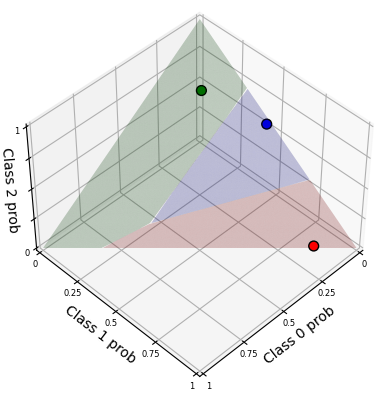

In [14]:
centroids_candidates = sample_uniform_random_vectors_over_simplex(n=3, d=3, random_state=11)

nn_candidates = NearestNeighbors(n_neighbors=1, p=2).fit(centroids_candidates)

ax = clean_simplex_ax(plot_3d_regions_over_simplex(nn_candidates))
ax.scatter(
    xs=centroids_candidates[:, 0],
    ys=centroids_candidates[:, 1],
    zs=centroids_candidates[:, 2],
    c=['r', 'b', 'g'], s=50, edgecolor='k', alpha=1
)
plt.show()

Essa lógica de reordenação e reamostragem em casos patológicos está implementada na função `sample_valid_random_vectors_over_simplex`.

In [15]:
def sample_valid_random_vectors_over_simplex(n, random_state=None):
    """Sample n unique points in the n-simplex with respect to their nearest
    neighbors.

    Parameters
    ----------
    n : int
        The number of unique points to sample and also the dimension of the
        simplex.

    random_state : int or None, default=None
        Controls the random number generator used for sampling.
        Pass an int for reproducible results across multiple function calls.

    Returns
    -------
    sampled_points : array-like of shape (n, n)
        The n uniformly random vectors in the n-simplex respecting the
        restriction that each end of the simplex needs to be associated
        with only one of these points.

    Examples
    --------
    >>> unique_points = sample_unique_points(3)
    """
    def _sample_and_check(n, random_gen):
        sample = sample_uniform_random_vectors_over_simplex(
            n=n, d=n, random_state=random_gen
        )
        edges = np.identity(n)
        nn_sample = NearestNeighbors(n_neighbors=1, p=2).fit(sample)
        _, ind_edges = nn_sample.kneighbors(edges)

        if len(np.unique(ind_edges[:, 0])) == n:
            # This only happens when each simplex edge is associated with only
            # one "centroid candidate".
            return sample[ind_edges[:, 0]], True
        else:
            return None, False

    sampled_points, success = _sample_and_check(n, random_state)

    while not success:
        random_state = (
            np.random.RandomState(random_state)
            .randint(0, 2**32 - 1, dtype=np.int64)
        )
        sampled_points, success = _sample_and_check(n, random_state)

    return sampled_points

Com essa garantia, temos sempre regiões bem definidas, no sentido de cada centroide incluir uma, e apenas uma, das quinas.

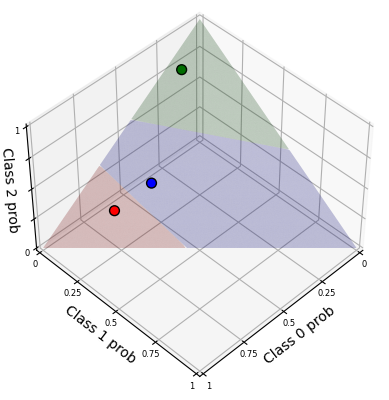

In [16]:
centroids_candidates = sample_valid_random_vectors_over_simplex(n=3, random_state=11)

nn_candidates = NearestNeighbors(n_neighbors=1, p=2).fit(centroids_candidates)

ax = clean_simplex_ax(plot_3d_regions_over_simplex(nn_candidates))
ax.scatter(
    xs=centroids_candidates[:, 0],
    ys=centroids_candidates[:, 1],
    zs=centroids_candidates[:, 2],
    c=['r', 'b', 'g'], s=50, edgecolor='k', alpha=1
)
plt.show()

___

## Busca aleatória

Com a função anterior retornando candidatos de centroides que respeitam as restrições básicas discutidas, podemos fazer uma estratégia força bruta para encontrar uma quebra possivelmente melhor que a quebra do [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html). Em pseudo-código, a ideia do algoritmo é:

```plaintext
1. Sample a valid set of points (centroid candidates) on the simplex (meaning,
there is a bijection between each corner of the simplex and its nearest
centroid).
2. Translate probabilities into hard predictions by associating each
probability with the centroid closest to it.
3. Calculate your threshold-dependent metric of interest with the hard
predictions computed in step 2.
4. Repeat steps 1, 2, and 3 the desired number of times and store the centroids
that yield the best result in the metric of interest.
```

Como a busca é aleatória, podemos paralelizar ela de uma maneira bem direta com o [`joblib.Parallel`](https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html), obtendo a função `optmize_threshold_multiclass_metric`.

In [17]:
from joblib import Parallel, delayed

def optmize_threshold_multiclass_metric(
    y_proba, y_true, metric, n_iterations=100_000, n_jobs=-1
):
    """
    Optimize the threshold-dependent multiclass metric by sampling valid random
    vectors over the simplex and computing the metric for each set of centroids.
    
    Parameters
    ----------
    y_proba : array-like of shape (n_samples, n_classes)
        Probability estimates for each sample and class.
        
    y_true : array-like of shape (n_samples,)
        True class labels for each sample.
        
    metric : callable
        A callable function that takes two arguments (y_true, y_pred) and
        computes the threshold-dependent metric of interest.
        
    n_iterations : int, optional, default=100_000
        The number of iterations to perform when searching for the best set
        of centroids.
        
    n_jobs : int, optional, default=-1
        The number of CPU cores to use for parallel execution. -1 means using
        all processors.
        
    Returns
    -------
    max_metric_search : float
        The maximum value of the metric found during the search.
        
    best_centroids : array-like of shape (n_classes, n_classes)
        The set of centroids that yielded the maximum metric value.
    """
    dimension = y_proba.shape[1]

    def _compute_metric(rs, y_proba, y_true, metric):
        centroids = sample_valid_random_vectors_over_simplex(
            dimension, random_state=rs
        )
        nn_centroids = NearestNeighbors(n_neighbors=1, p=2).fit(centroids)
        _, new_preds = nn_centroids.kneighbors(y_proba)
        return metric(y_true, new_preds[:, 0])

    metric_list = Parallel(n_jobs=n_jobs)(
        delayed(_compute_metric)(rs, y_proba, y_true, metric)
        for rs in tqdm(range(n_iterations))
    )

    best_random_state = np.argmax(metric_list)
    max_metric_search = np.max(metric_list)
    best_centroids = sample_valid_random_vectors_over_simplex(
        dimension, random_state=best_random_state
    )

    return max_metric_search, best_centroids


___

## Aplicando a estratégia

Por exemplo, para os dados que estamos exemplificando ao longo desse post, podemos procurar quebras melhores que a quebra natural do np.argmax baseado na otimização do [sklearn.metrics.matthews_corrcoef](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), por exemplo.

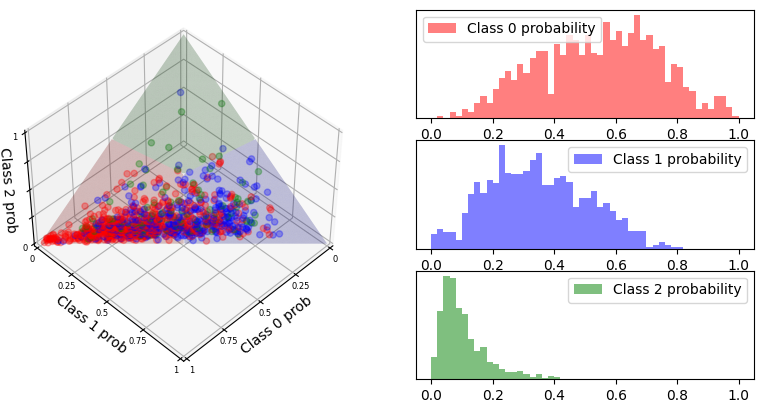

In [18]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig = plt.figure(figsize=plt.figaspect(0.5))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax = (
    fig.add_subplot(gs[:, 0], projection='3d'),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2, 1])
)

clean_simplex_ax(plot_3d_regions_over_simplex(nn, ax[0]))
color_list_nn = [
    color_dic[x] for x in np.array(y_train_threshold)[plot_sample]
]
ax[0].scatter(
    xs=probs[plot_sample, 0],
    ys=probs[plot_sample, 1],
    zs=probs[plot_sample, 2],
    c=color_list_nn, alpha=0.3
)

bins = np.linspace(0, 1, 51)
for class_, color in enumerate(['r', 'b', 'g']):
    ax[class_ + 1].hist(
        probs[plot_sample, class_], bins=bins, alpha=0.5,
        color=color, label=f"Class {class_} probability"
    )
    ax[class_ + 1].set_yticks([])
    ax[class_ + 1].legend()

plt.show()

Aplicando nossa estratégia, temos:

In [19]:
from functools import partial
from sklearn.metrics import matthews_corrcoef#, fbeta_score

metric = matthews_corrcoef
# metric = partial(fbeta_score, beta=4, average="micro")
# metric.__name__ = fbeta_score.__name__

max_metric, best_centroids = optmize_threshold_multiclass_metric(
    probs, y_train_threshold, metric, n_iterations=100_000, n_jobs=-1
)

100%|██████████| 100000/100000 [10:49<00:00, 153.96it/s]


E conseguimos comparar tanto a divisão do simplex quanto a métrica obtida com essa nova quebra:

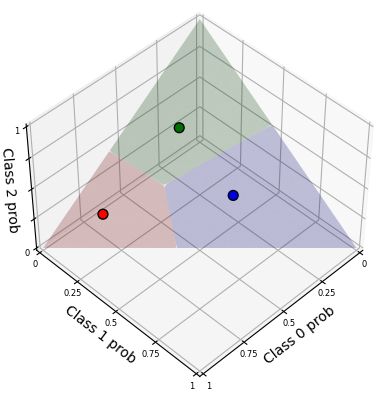

In [20]:
nn_best_centroids = NearestNeighbors(n_neighbors=1, p=2).fit(best_centroids)

ax = clean_simplex_ax(plot_3d_regions_over_simplex(nn_best_centroids))
ax.scatter(
    xs=best_centroids[:, 0],
    ys=best_centroids[:, 1],
    zs=best_centroids[:, 2],
    c=['r', 'b', 'g'], s=50, edgecolor='k', alpha=1
)
plt.show()

In [21]:
_, new_preds = nn_best_centroids.kneighbors(model.predict_proba(X_test))
old_preds = model.predict(X_test)

print(f"{metric.__name__} of usual predict: {matthews_corrcoef(y_test, old_preds)}")
print(f"{metric.__name__} of optimized predict: {matthews_corrcoef(y_test, new_preds[:, 0])}")

matthews_corrcoef of usual predict: 0.22384931642747133
matthews_corrcoef of optimized predict: 0.24023142509917905


___

## Considerações finais

Acho que a principal contribuição da técnica deseolvida aqui é a forma como ela parametriza o espaço de busca de regiões do simplex. Diferente da classificação binária em que variar o threshold é super imediato, a parametrização da quebra do simplex (principalmente para um numéro de classes maior que 3) é extremamente complexa e não intuitiva.

A abordagem descrita aqui generaliza a observação de que uma busca de vizinhos com as quinas do simplex é equivalente ao `.predict` usual nos dando um jeito de procurar novas quebras do simplex mexendo nas posições dos pontos que vamos usar para a busca de vizinhos. Consequentemente, a nossa parametrização é dada justamente pela posição desses centroides no simplex.

___

## Algumas ideais para o futuro e cuidados com a utilização dessa técnica:

- Aqui estamos explorando a distância euclideana (Minkowski com p=2) em cima do simplex. Ela, com os centroides nas quinas do simplex, coincide exatamente com a forma como o `.predict` com [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) funciona. Entretanto, estamos explorando variações disso e, por isso, não necessariamente precisamos nos prender a essa métrica. Uma fácil varição da ideia proposta aqui mudaria o valor do `p` para ver sua influência.


- É possível mudar as restrições impostas nos candidatos a centroides. Essas pareciam razoáveis para mim, mas podem não ser as melhores.


- Aqui eu introduzo a ideia fazendo um random search, que pode ser facilmente paralelizado. A paralelização é muito útil já que nosso espaço de busca é relativamente de grande pela sua alta dimensão: procuramos `n**2` parâmetros em que `n` é o número de classes (`n` centroides com `n` componentes determinando sua posição no simplex). Entretanto, talvez uma camada final de otimização bayesiana pode nos levar a soluções ligeriamente melhores, com uma busca mais eficiente ao final da força bruta.


- Como observado anteriormente, o espaço de busca é razoávelmente grande quando estamos em dimensão alta. Ainda, o sample aleatório amostrado do simplex pode estar em regiões pouco exploradas pelo seu `.predict_proba` que pode estar concentrado em algumas regiões do seu simplex. Uma ideia para não amostrar em regiões pouco exploradas pode ser amostrar diretamente em cima do seu `.predict_proba`.


- Utilizar essa estratégia exige que você quebre o seu conjunto em três partes: treino do modelo, treino do threshold e avaliação. Diferente da classificação binária, num cenário multiclasse, você tem `n**2` parâmetros para definir a sua quebra do simplex, como comentado anteriormente, em contraste com apenas um anteriormente, que era o que chamavá-mos de threshold. Principalmente em casos de desbalanço absoluto, quando você tem um conjunto de treino muito pequeno, isso pode facilmente overfitar no seu conjunto de calibração. Num cenário de poucos dados, talvez não tenha muito como fugir de implementar alguma surrogate loss que transforme sua função de custo não diferenciável em algo mais tratável, como, por exemplo, [essa para a F1](https://arxiv.org/abs/2108.10566). Utilizando todo o seu conjunto de treino efetivamente para treino do modelo e utilizando o `.predict` usual mesmo.


- Vale plotar (se você estiver em um cenário de 3 classes) suas probabilidades do seu conjunto de calibração de threshold no simplex ou fazer histogramas das probabilidades de cada classe, como fizemos no nosso exemplo aplicado, para avaliar se faz sentido a ou não a otimização. Se seu modelo é muito confiante e as probabilidades estão muito próximas da bordas, é provável que ele tenha mais dificuldade de resolver esses casos. Intuitivamente, da forma como vejo, seu maior ganho é quando há exemplos suficientes no interior do simplex para que a troca de classe seja relevante.

___